# 0. Imports

In [2]:
from sampling.conditional_probability_path import ConditionalProbabilityPath, GaussianConditionalProbabilityPath
from sampling.noise_scheduling import LinearAlpha, LinearBeta
from sampling.sampleable import PixelArtSampler

import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
import random
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Plot data examples

In [3]:
def plot_examples(num_rows: int = 3, num_cols: int = 5, dir: str = '../dataset/images'):
    all_files = [f for f in os.listdir(dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    total_images = num_rows * num_cols

    if len(all_files) < total_images:
        raise ValueError(f"Not enough images in the folder. Needed: {total_images}, found: {len(all_files)}")

    selected_files = random.sample(all_files, total_images)

    # Plotting
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axs = axs.flatten()

    for ax, filename in zip(axs, selected_files):
        img_path = os.path.join(dir, filename)
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

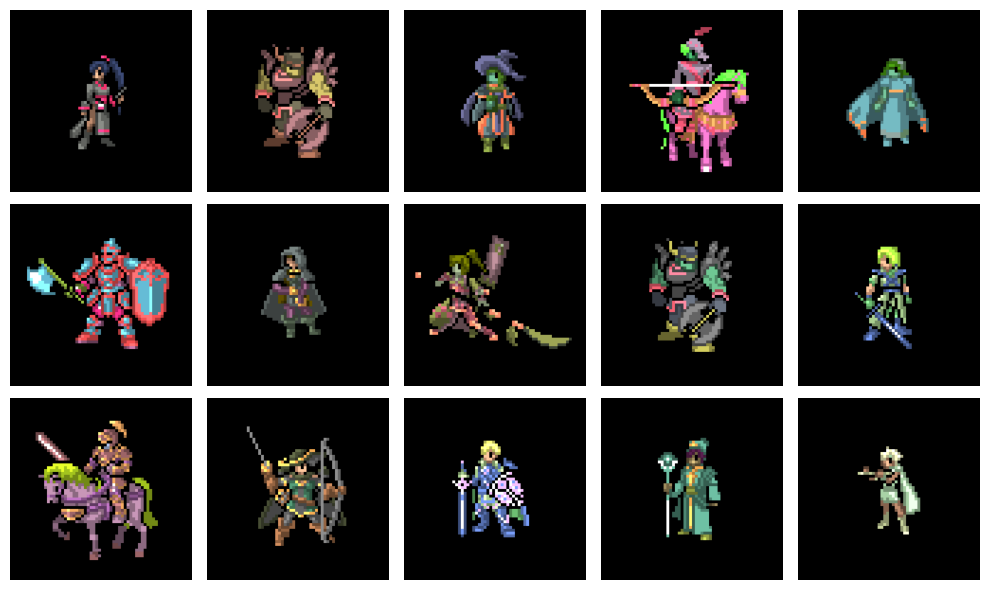

In [3]:
plot_examples()

# 2. Plot denoising timesteps

In [7]:
def sample_and_plot(
        path: ConditionalProbabilityPath,
        num_rows: int = 3,
        num_cols: int = 3,
        num_timesteps: int = 4,
        mode: str = 'train'
):
    num_samples = num_cols * num_rows
    z = path.p_data.sample(num_samples, mode=mode)
    z = z.view(-1, 3, 128, 128)

    fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

    ts = torch.linspace(0, 1, num_timesteps).to(device)

    for t_idx, t in enumerate(ts):
        tt = t.view(1, 1, 1, 1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
        xt = path.sample_conditional_path(z, tt) # (num_samples, 3, 128, 128)
        grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
        axes[t_idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[t_idx].axis("off")

    plt.show()

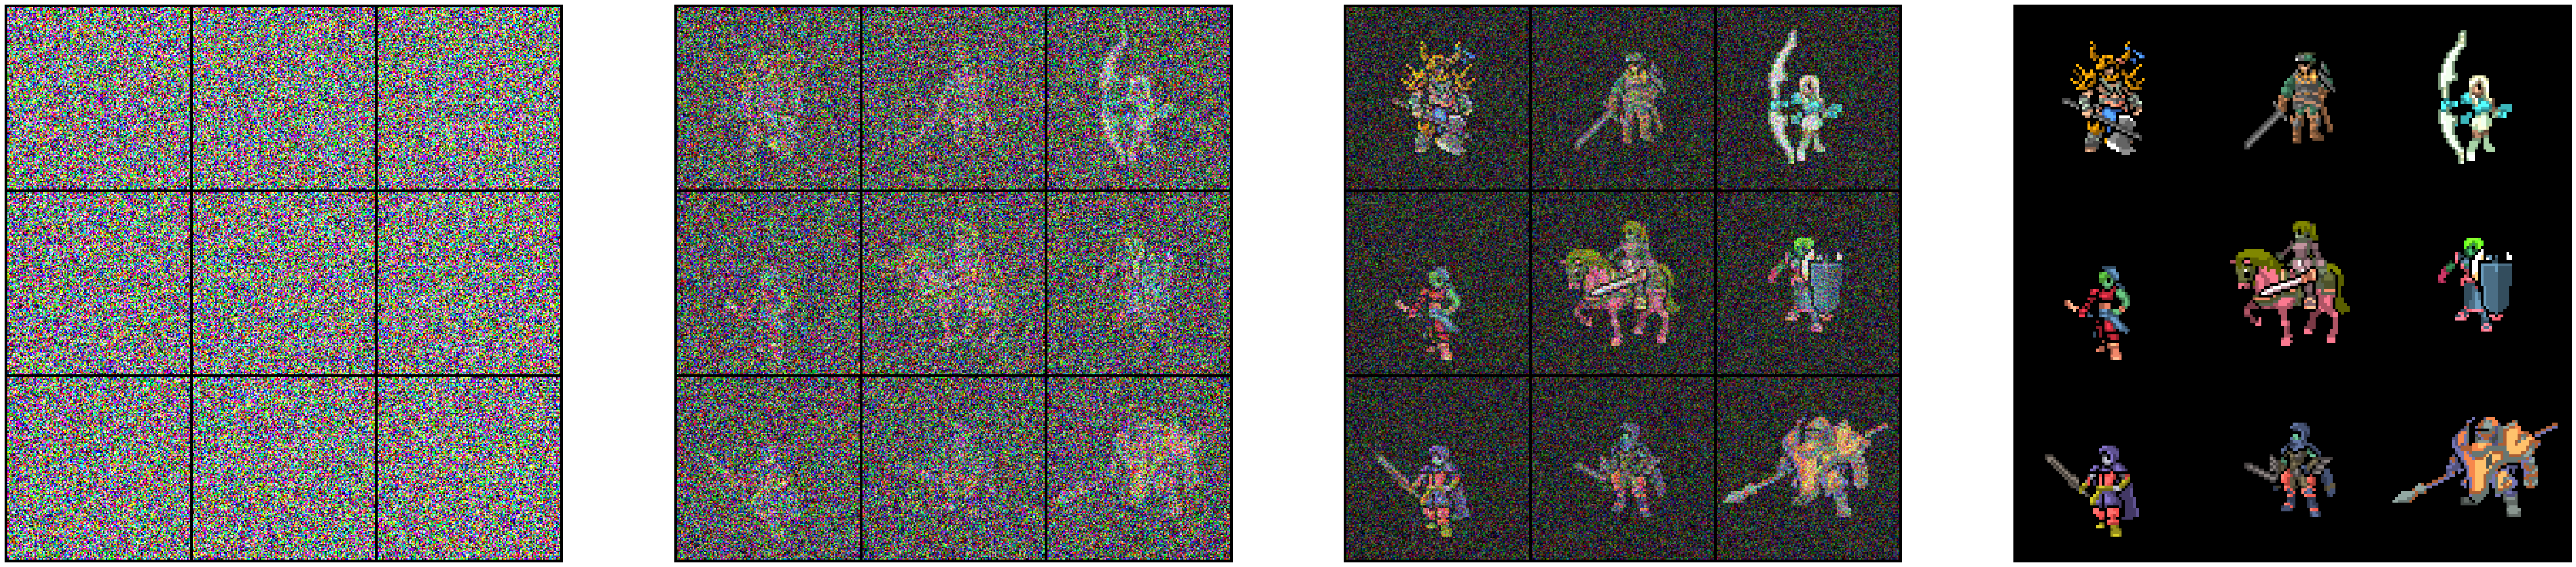

In [13]:
sampler = PixelArtSampler(root_dir='../dataset/images').to(device)

path = GaussianConditionalProbabilityPath(p_data=sampler,
                                          p_simple_shape=[1, 128, 128],
                                          alpha=LinearAlpha(),
                                          beta=LinearBeta(),
                                          ).to(device)

sample_and_plot(path, mode='train')